### Student Information
Name: leo lin

Student ID: 109003814

GitHub ID: leolin65

Kaggle name: leolin65

Kaggle private scoreboard snapshot:

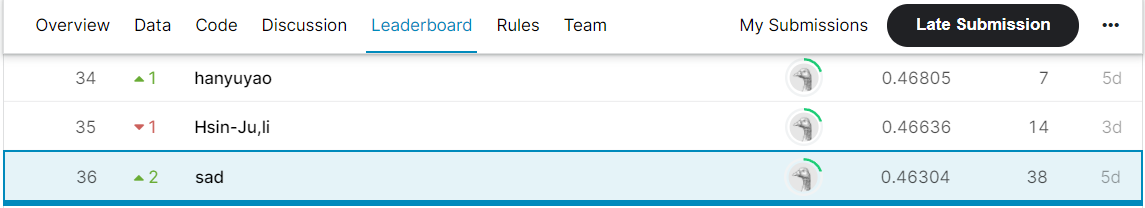

---

### Instructions

## 1. Data Preparation

## 1.1 Load data

1. data_identification: define which twitter ID are train and which one are test data(csv)
2. emotion: Label(Emotion) for train data(csv)
3. tweets_DM: data contain score, date hashtag, tweetid and text data from twitter(json)

In [1]:
import pandas as pd
pd.set_option('max_colwidth', 400)



from functools import partial

import nltk
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer



In [2]:
data_identification = pd.read_csv("data_identification.csv")
emotion = pd.read_csv("emotion.csv")

In [3]:
print(data_identification)

         tweet_id identification
0        0x28cc61           test
1        0x29e452          train
2        0x2b3819          train
3        0x2db41f           test
4        0x2a2acc          train
...           ...            ...
1867530  0x227e25          train
1867531  0x293813          train
1867532  0x1e1a7e          train
1867533  0x2156a5          train
1867534  0x2bb9d2          train

[1867535 rows x 2 columns]


In [4]:
print(emotion)

         tweet_id       emotion
0        0x3140b1       sadness
1        0x368b73       disgust
2        0x296183  anticipation
3        0x2bd6e1           joy
4        0x2ee1dd  anticipation
...           ...           ...
1455558  0x38dba0           joy
1455559  0x300ea2           joy
1455560  0x360b99          fear
1455561  0x22eecf           joy
1455562  0x2fb282  anticipation

[1455563 rows x 2 columns]


for json data we need to normalize (split it into seperate columns)

In [5]:
import json
tweets_DM = pd.read_json (r'tweets_DM.json',lines=True,orient='columns')
#normalize json data
data = tweets_DM['_source'].tolist()
df = pd.DataFrame.from_dict(pd.json_normalize(data), orient='columns')
tweets_DM= pd.concat([tweets_DM, df], axis=1)

In [6]:
print(tweets_DM)

         _score          _index  \
0           391  hashtag_tweets   
1           433  hashtag_tweets   
2           232  hashtag_tweets   
3           376  hashtag_tweets   
4           989  hashtag_tweets   
...         ...             ...   
1867530     827  hashtag_tweets   
1867531     368  hashtag_tweets   
1867532     498  hashtag_tweets   
1867533     840  hashtag_tweets   
1867534     360  hashtag_tweets   

                                                                                                                                                                                                                  _source  \
0                                                              {'tweet': {'hashtags': ['Snapchat'], 'tweet_id': '0x376b20', 'text': 'People who post "add me on #Snapchat" must be dehydrated. Cuz man.... that's <LH>'}}   
1          {'tweet': {'hashtags': ['freepress', 'TrumpLegacy', 'CNN'], 'tweet_id': '0x2d5350', 'text': '@brianklaas As we see, Trump is d

Compress size for saving memory space

In [7]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% Compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [8]:
tweets_DM = downcast(tweets_DM)
data_identification = downcast(data_identification)
emotion = downcast(emotion)

9.4% Compressed
0.0% Compressed
0.0% Compressed


In [9]:
data_identification

,tweet_id,identification
0,0x28cc61,test
1,0x29e452,train
2,0x2b3819,train
3,0x2db41f,test
4,0x2a2acc,train
...,...,...
1867530,0x227e25,train
1867531,0x293813,train
1867532,0x1e1a7e,train
1867533,0x2156a5,train


In [10]:
#rename column
tweets_DM= tweets_DM.rename(columns={'tweet.tweet_id': 'id', 'tweet.text': 'text','tweet.hashtags':'hashtags'})
#Drop unused columns
tweets_DM=tweets_DM.drop(['_source','_index','_type','_score', '_crawldate','hashtags'], axis=1)
data_identification= data_identification.rename(columns={'tweet_id': 'id'})
emotion= emotion.rename(columns={'tweet_id': 'id'})
#put it in new dataframe
Text = tweets_DM

Dividing train and test set data

In [11]:
traindata=data_identification[data_identification['identification']=='train']
traindata = pd.merge(traindata, Text,  how='left', left_on=['id'], right_on = ['id'])
traindata = pd.merge(traindata, emotion,  how='left', left_on=['id'], right_on = ['id'])
Testdata=data_identification[data_identification['identification']=='test']
Testdata = pd.merge(Testdata, Text,  how='left', left_on=['id'], right_on = ['id'])

print(traindata.shape)
print(Testdata.shape)

(1455563, 4)
(411972, 3)


In [12]:
# shuffle dataset
traindata = traindata.sample(frac=1)
Testdata = Testdata.sample(frac=1)
print(traindata.shape)
print(Testdata.shape)

(1455563, 4)
(411972, 3)


### 1.2 Save data

save data in Pickle format to continue without doing the previous step againn.

In [13]:
traindata.to_pickle("traindata.pkl")
Testdata.to_pickle("Testdata.pkl")

resume from saved file

In [14]:
import pandas as pd
traindata = pd.read_pickle("traindata.pkl")
Testdata = pd.read_pickle("Testdata.pkl")

Check if there is missing values in both train and test dataset

In [15]:
import helpers.data_mining_helpers as dmh
traindata.isnull().apply(lambda x: dmh.check_missing_values(x))

,id,identification,text,emotion
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0,0


In [16]:
Testdata.isnull().apply(lambda x: dmh.check_missing_values(x))

,id,identification,text
0,The amoung of missing records is:,The amoung of missing records is:,The amoung of missing records is:
1,0,0,0


# 1.3 Cleaning text from tweet

see text lenght and words count for each tweet before cleaning

In [17]:
traindata['textlen'] = [len(t) for t in traindata['text']]
Testdata['textlen'] = [len(t) for t in Testdata['text']]
traindata['word_count'] = traindata['text'].apply(lambda x: len(str(x).split(" ")))
Testdata['word_count'] = Testdata['text'].apply(lambda x: len(str(x).split(" ")))

In [18]:
traindata

,id,identification,text,emotion,textlen,word_count
355821,0x2e3ded,train,Traveling 2 hours to lose the way we did.... disappointed to say the least. @tombradshaw92 scored then got taken off?? #confused.com,sadness,133,22
89944,0x333a3d,train,Melatonin you are my friend and the only reason I sleep 😴 #insomnia #bipolar #rapidcycling <LH> #mentalhealth 😢,anger,111,18
1062540,0x27444d,train,"@vivchook Well, get me one too! 😂 Rudeness seems so much easier for some on social media. <LH>",sadness,94,18
1190885,0x2b0378,train,@ellisonprinting Thanks Jane ♥ husband in hospital. Busy up & down. Show @deanclough staying #optimistic. Hope all good with you.,joy,132,23
649939,0x22c7fc,train,Hey @realDonaldTrump when ur done marginalizing the <LH> #MilitaryBan & #Pardoning #JoeArpaio #Texas might need you #HurricaneHarvey <LH>,disgust,137,18
...,...,...,...,...,...,...
642098,0x2ef5e1,train,Phil Parker drops two deep. Huh? Blittz! It was 3rd and 12 @IowaFootball. <LH>,sadness,78,14
1437639,0x36951c,train,"""If you God is dead"" ~ #BrookBenton 😍 #MyTop10At10 😊 WOW!!!!! My childhood days were filled with joyous moments. Thank you @tboseZA <LH>",joy,136,23
108067,0x38222c,train,Oh my god got one almighty headache this morning <LH> #headache,disgust,63,11
333393,0x249c4e,train,God has never failed me!!! <LH>,joy,31,6


Create Function to clean text from tweet

Because texts from tweets is too messy so i'll do some cleaning before doing EDA
These are the following steps that I do for text cleaning:

0. Replace emoticon with text
1. Replace emoji with text
2. Remove whitespace/url/mentions/hashtags/HTML/multiple letter/special letter
3. Lowercase
4. Replace contractions/slangs

For emoticon, contraction, and slang  I found a list of both things from github and I will use them to replace the original text(credit: https://github.com/Deffro/text-preprocessing-techniques/blob/master/techniques.py)

In [19]:
# defined emoticon
def load_dict_smileys():
    
    return {
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love"
        }

In [20]:
# defined contractions/slangs
def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "I'd":"I would",
        "I'll":"I will",
        "I'm":"I am",
        "I'm'a":"I am about to",
        "I'm'o":"I am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "I've":"I have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "Whatcha":"What are you",
        "luv":"love",
        "u":"you",
        "r":"are",
        "sux":"sucks",
        "2day":"today",
        "2nite":"tonight",
        "4u":"for you",
        "4ward":"forward",
        "a3":"anyplace, anywhere, anytime",
        "a/n":"author note",
        "a/w":"anyway",
        "a/s/l":"age, sex, location",
        "adn":"any day now",
        "afaic":"as far as i'm concerned",
        "afaik":"as far as I know",
        "afk":"away from keyboard",
        "aggro":"aggresive",
        "aight":"alright",
        "airhead":"stupid",
        "aka":"as known as",
        "alol":"actually laughing out loud",
        "amigo":"friend",
        "amz":"amazing",
        "app":"application",
        "armpit":"undesirable",
        "asap":"as soon as possible",
        "atm":"at the moment",
        "atw":"all the way",
        "b/c":"because",
        "b-day":"birthday",
        "b4":"before",
        "b4n":"bye for now",
        "bae":"before anyone else",
        "bak":"back at the keyboard",
        "bbl":"bee back later",
        "bday":"birthday",
        "becuz":"because",
        "bent":"angry",
        "bestie":"best friend",
        "besty":"best friend",
        "bf":"boyfriend",
        "bff":"best friends forever",
        "bffe":"best friends forever",
        "bfn":"bye for now",
        "bg":"big grin",
        "bmfe":"best mates forever",
        "bmfl":"best mates life",
        "bozo":"idiot",
        "brah":"friend",
        "bravo":"well done",
        "brb":"be right back",
        "bro":"brother",
        "bta":"but then again",
        "btdt":"been there, done that",
        "btr":"better",
        "btw":"by the way",
        "buddy":"friend",
        "c'mon":"came on",
        "cid crying in disgrace":"",
        "congrats congratulations":"",
        "copacetic excellent":"",
        "coz beacause":"",
        "cu":"see you",
        "cuddy":"friends",
        "cul":"see you later",
        "cul8r":"see you later ",
        "cutie":"cute",
        "cuz":"because",
        "cya":"bye",
        "cyo":"see you online ",
        "dbau":"doing business as usual",
        "deets":"details",
        "dmn":"damn",
        "dobe":"idiot",
        "dope":"stupid",
        "dork":"strange",
        "dunno":"don't know",
        "dwi":"deal with it",
        "dyd":"don't you dare",
        "ermahgerd":"oh my gosh",
        "eu":"europe",
        "ez":"easy",
        "f9":"fine",
        "fav":"favorite",
        "far-out":"great",
        "fb":"facebook",
        "flick":"movie",
        "fml":"fuck my life",
        "foxy":"sexy",
        "friggin":"freaking",
        "fttn":"for the time being",
        "ftw":"for the win",
        "fud":"fear, uncertainty, and doubt",
        "fwiw":"for what it's worth ",
        "fyi":"for your information",
        "g":"grin ",
        "g2g":"got to go ",
        "ga":"go ahead ",
        "gal":"get a life",
        "getcha":"understand ",
        "gf":"girlfriend ",
        "gfn":"gone for now",
        "gg":"good game",
        "gj":"good job",
        "gky":"go kill yourself",
        "gl":"good luck",
        "glhf":"good luck have fun",
        "gmab":"give me a break",
        "gmbo":"giggling my butt off ",
        "gmta":"great minds think alike ",
        "goof":"idiot",
        "goofy":"idiot",
        "gr8":"great",
        "gtg":"got to go",
        "gud":"good",
        "h8":"hate",
        "hagn":"have a good night ",
        "hdop":"help delete online predators ",
        "hf":"have fun",
        "hml":"hate my life",
        "hoas":"hold on a second",
        "hhis":"hanging head in shame ",
        "hmu":"hit me up",
        "hru":"how are you",
        "twt":"hope this helps",
        "hw":"homework",
        "im":"i am",
        "i'ma":"i am going to",
        "iac":"in any case ",
        "ic":"I see ",
        "icymi":"in case you missed it",
        "idk":"I don't know",
        "iggy":"ignore ",
        "iht":"i hate this",
        "ikr":"i know, right?",
        "ilt":"i like that",
        "ily":"i love you",
        "ima":"i am going to ",
        "imao":"in my arrogant opinion",
        "imnsho":"in my not so humble opinion ",
        "imo":"in my opinion ",
        "imy":"i miss you",
        "iou":"i owe you",
        "iow":"in other words ",
        "ipn":"I’m posting naked ",
        "irl":"in real life ",
        "j/k":"just kidding",
        "jdi":"just do it",
        "jk":"just kidding",
        "jkn":"joking",
        "jyeah":"yeah",
        "kinda":"kind of",
        "l8":"late",
        "l8r":"later",
        "lbh":"let's be honest",
        "ld":"later, dude",
        "ldi":"let's do it  ",
        "ldr":"long distance relationship ",
        "lees":"beautiful ",
        "lfm":"looking for more",
        "lil":"little",
        "llta":"lots and lots of thunderous applause ",
        "lmao":"laugh my ass off",
        "lmirl":"let's meet in real life ",
        "lmk":"let me know",
        "lol":"laugh out loud",
        "lolz":"laugh out loud",
        "lotta":"lot of",
        "lsr":"loser",
        "ltr":"longterm relationship",
        "lua":"love you always ",
        "lub":"love",
        "lubb":"love",
        "lulab":"love you like a brother ",
        "lulas":"love you like a sister ",
        "lul":"laugh",
        "luls":"laugh",
        "lulz":"laugh",
        "lumu":"love you miss you",
        "luv":"love",
        "lux":"luxury",
        "lwm":"laugh with me",
        "lwp":"laugh with passion",
        "lvl":"level",
        "m/f":"male or female",
        "m2":"me too",
        "m8":"mate",
        "me2":"me too",
        "milf":"mother I would like to fuck",
        "mma":"meet me at",
        "mmb":"message me back",
        "mvp":"most valueable player",
        "msg":"message",
        "mtf":"more to follow",
        "myob":"mind your own business",
        "nah":"no",
        "nc":"no comment",
        "nk":"not kidding",
        "ngl":"not gonna lie",
        "nlt":"no later than",
        "nm":"not much",
        "no1":"no one",
        "np":"no problem",
        "nsfw":"not safe for work",
        "nuh":"no",
        "nvm":"nevermind",
        "obo":"or best offer",
        "oic":"oh, i see",
        "oll":"online love ",
        "omg":"oh my god",
        "omw":"on my way",
        "osm":"awesome",
        "otoh":"on the other hand ",
        "perv":"pervert",
        "pervy":"pervert",
        "phat":"pretty hot and tempting",
        "pir":"parent in room",
        "pls":"please",
        "plz":"please",
        "ppl":"people",
        "pro":"professional",
        "pwnd":"owned",
        "qq":"crying",
        "r":"are",
        "rly":"really",
        "rofl":"roll on the floor laughing",
        "rolf":"roll on the floor laughing",
        "rpg":"role playing games",
        "ru":"are you",
        "s2u":"shame to you",
        "scrub":"loser",
        "sec":"second",
        "shid":"slaps head in disgust",
        "shoulda":"should have",
        "sff":"so funny",
        "smexy":"smart and sexy",
        "smh":"shaking my head",
        "somy":"sick of me yet",
        "sot":"short of time ",
        "sry":"sorry",
        "str8":"straight",
        "sux":"sucks",
        "swag":"style",
        "taze":"irritate",
        "tba":"to be announced",
        "tbfu":"too bad for you",
        "tbc":"to be continued",
        "tbd":"to be determined",
        "tbr":"to be rude",
        "tc":"take care",
        "thx":"thanks",
        "thanx":"thanks",
        "thx":"thanks",
        "tfw":"that feeling  when",
        "til":"today i learned",
        "ttyl":"talk to you later ",
        "ty":"thank you",
        "tyvm":"thank you very much",
        "u":"you",
        "uber":"the best",
        "ugh":"disgusted",
        "ur":"you are",
        "uw":"you are welcome ",
        "vs":"versus",
        "w2f":"way too funny",
        "w8":"wait",
        "wak":"weird",
        "wanna":"want to",
        "wb":"welcome back",
        "whiz":"talented",
        "whoa":"surprise",
        "whoah":"surprise",
        "wfm":"works for me ",
        "wibni":"wouldn't it be nice if ",
        "wmd":"weapon of mass destruction",
        "wot":"what",
        "wtf":"what the fuck",
        "wtg":"way to go",
        "wtgp":"want to go private",
        "wu":"what's up",
        "wuh":"what?",
        "wuv":"love",
        "ym":"young man",
        "yawn":"boring",
        "yum":"good",
        "x":"kiss",
        "xxx":"kiss",
        "xdd":"laughing",
        "y":"why",
        "yolo":"you only live once",
        "yuge":"huge",
        "yw":"you are welcome",
        "ywa":"you are welcome anyway",
        "zomg":"oh my god!",
        "zzz":"sleeping"    
        }

In [21]:
#replace emoticon with words in the dictionary
emoticon=load_dict_smileys()
def demoticon(text):
    text = text.replace("’","'")
    words = text.split()
    text = [emoticon[text] if text in emoticon else text for text in words]
    text = " ".join(text)
    return text

In [22]:
#https://pypi.org/project/emoji/
#if ImportError: cannot import name 'UNICODE_EMOJI' from 'emoji', reinstall below.
#pip uninstall emoji
#https://anaconda.org/conda-forge/emoji
#conda install -c conda-forge emoji==1.6.3

import emoji
from emoji import emojize
# add space before and after the emoji
from emoji import UNICODE_EMOJI
def is_emoji(s, language="en"):
    return s in UNICODE_EMOJI[language]
    
def add_space(text):
    return ''.join(' ' + char + ' 'if is_emoji(char) else char for char in text).strip()

In [23]:
#replace emoji using emoji library
def demoji(text):
    text = emoji.demojize(text, delimiters=("", " "))  
    return text

In [24]:
#clean noisy data
import re
import itertools
def cleaning_text(text):    
    text = text.strip() # remove white space
    text = re.sub(r'http\S+', "", text)    # remove urls
    text = re.sub(r'@\w+','',text)         # remove mentions
    text = re.sub(r'#', '', text)       # remove hastags \w+
    text = re.sub(r'<\w+','', text)       # remove html tags
    text = re.sub(r'<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});', '', text) 
    text = re.sub(r'>', '', text)
    text = ''.join(''.join(s)[:2] for _, s in itertools.groupby(text)) # remove multiple letters
    text = text.lower()  #convert to lower case
    text = re.sub('[!,*)@#%(&$_?.^+->:;/\"]', '', text)
    return text

In [25]:
#replace the contractions
CONTRACTIONS=load_dict_contractions()
def replaceconslang(text):
    text = text.replace("’","'")
    words = text.split()
    text = [CONTRACTIONS[text] if text in CONTRACTIONS else text for text in words]
    text = " ".join(text)
    text =re.sub('[^a-zA-Z0-9 \n\.]', '', text)
    return text

Apply function to dataframe & insert into new column

In [26]:
%%time
traindata['cleantext']=traindata['text'].apply(lambda x: demoticon(x))
Testdata['cleantext']=Testdata['text'].apply(lambda x: demoticon(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: add_space(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: add_space(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: demoji(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: demoji(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: cleaning_text(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: cleaning_text(x))
traindata['cleantext']=traindata['cleantext'].apply(lambda x: replaceconslang(x))
Testdata['cleantext']=Testdata['cleantext'].apply(lambda x: replaceconslang(x))

CPU times: total: 3min 2s
Wall time: 3min 2s


In [27]:
traindata['textlenafter']=[len(t) for t in traindata['cleantext']]
traindata['word_countafter'] = traindata['cleantext'].apply(lambda x: len(str(x).split(" ")))

In [28]:
traindata

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter
355821,0x2e3ded,train,Traveling 2 hours to lose the way we did.... disappointed to say the least. @tombradshaw92 scored then got taken off?? #confused.com,sadness,133,22,traveling hours to lose the way we did disappointed to say the least scored then got taken off confusedcom,106,19
89944,0x333a3d,train,Melatonin you are my friend and the only reason I sleep 😴 #insomnia #bipolar #rapidcycling <LH> #mentalhealth 😢,anger,111,18,melatonin you are my friend and the only reason i sleep sleepingface insomnia bipolar rapidcycling mentalhealth cryingface,122,17
1062540,0x27444d,train,"@vivchook Well, get me one too! 😂 Rudeness seems so much easier for some on social media. <LH>",sadness,94,18,well get me one too facewithtearsofjoy rudeness seems so much easier for some on social media,93,16
1190885,0x2b0378,train,@ellisonprinting Thanks Jane ♥ husband in hospital. Busy up & down. Show @deanclough staying #optimistic. Hope all good with you.,joy,132,23,thanks jane heartsuit husband in hospital busy up down show staying optimistic hope all good with you,101,17
649939,0x22c7fc,train,Hey @realDonaldTrump when ur done marginalizing the <LH> #MilitaryBan & #Pardoning #JoeArpaio #Texas might need you #HurricaneHarvey <LH>,disgust,137,18,hey when you are done marginalizing the militaryban pardoning joearpaio texas might need you hurricaneharvey,108,15
...,...,...,...,...,...,...,...,...,...
642098,0x2ef5e1,train,Phil Parker drops two deep. Huh? Blittz! It was 3rd and 12 @IowaFootball. <LH>,sadness,78,14,phil parker drops two deep huh blittz it was rd and,51,11
1437639,0x36951c,train,"""If you God is dead"" ~ #BrookBenton 😍 #MyTop10At10 😊 WOW!!!!! My childhood days were filled with joyous moments. Thank you @tboseZA <LH>",joy,136,23,if you god is dead brookbenton smilingfacewithhearteyes mytopat smilingfacewithsmilingeyes wow my childhood days were filled with joyous moments thank you,155,21
108067,0x38222c,train,Oh my god got one almighty headache this morning <LH> #headache,disgust,63,11,oh my god got one almighty headache this morning headache,57,10
333393,0x249c4e,train,God has never failed me!!! <LH>,joy,31,6,god has never failed me,23,5


i tried English Language Detection use fasttext

In [29]:
"""
Building fastText for Python
For now this is not part of a release, so you will need to clone the master branch.

$ git clone https://github.com/facebookresearch/fastText.git
$ cd fastText
$ pip install .

if happen below error
  error: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/
You should follow below instruction to install
https://www.scivision.dev/python-windows-visual-c-14-required

"""

import fasttext
pretrained_model = "lid.176.bin"  #download from https://fasttext.cc/docs/en/language-identification.html
model = fasttext.load_model(pretrained_model)
langs = []
for sent in traindata['cleantext']:
    lang = model.predict(sent)[0]
    langs.append(str(lang)[:])
traindata['langs'] = langs

In [30]:
traindata[~traindata["langs"].str.contains('en')]

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter,langs
154136,0x2f0169,train,@raymundop_ Wow que sexy boy .....#cool,joy,39,6,wow que sexy boy cool,21,5,"('__label__ca',)"
741070,0x37952f,train,"<LH> Oh lawd,Molly!!",fear,20,3,oh lawdmolly,12,2,"('__label__es',)"
560478,0x37deae,train,I love God <LH>,trust,15,4,i love god,10,3,"('__label__sv',)"
181224,0x2a8dbd,train,@LENALittleClosa <LH> lmfao @HawaiianChuch_,trust,44,5,lmfao,5,1,"('__label__ar',)"
304754,0x216e46,train,Honestly I'm just ready for <LH> now,fear,36,7,honestly im just ready for now,30,6,"('__label__de',)"
...,...,...,...,...,...,...,...,...,...,...
1274537,0x2c9710,train,@July_Mo <LH> x Pennywise,joy,25,4,kiss pennywise,14,2,"('__label__nl',)"
659144,0x29e830,train,<LH> heel say ‘watch @JohnTorode1 on @GoodFoodChannel’ @markgreenaway @nigelbrownchef @TheCurryGuy @chefgingernut @ChefJeremyPang,sadness,129,12,heel say watch on,18,5,"('__label__nl',)"
106579,0x31ba29,train,Wurstel for lunch!Even if a want to bad to tey bratwurst... #lunch <LH> #meat #wurstel,anticipation,86,15,wurstel for luncheven if a want to bad to tey bratwurst lunch meat wurstel,74,14,"('__label__de',)"
593565,0x2ab477,train,Rain <LH>,joy,9,2,rain,4,1,"('__label__ja',)"


But sometimes it detect english sentence to be in other language so I didn't remove these records

Check for Null and remove duplicated value

In [31]:
traindata[traindata.isna().any(axis=1)]

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter,langs


In [32]:
traindata[traindata.duplicated(['cleantext'], keep=False)]

,id,identification,text,emotion,textlen,word_count,cleantext,textlenafter,word_countafter,langs
199832,0x2257c3,train,@V2CigsUK wow how nice <LH>,joy,27,5,wow how nice,12,3,"('__label__en',)"
415133,0x1e3f31,train,"Closed Buy 1.4 Lots EURUSD 1.18502 for +10.0 pips, total for today +761.2 pips <LH> <LH> <LH> <LH> <LH>",joy,103,19,closed buy lots eurusd for pips total for today pips,52,10,"('__label__en',)"
1041647,0x382e0c,train,@BradKidd33 @cajunlady64 @DeepStateAgent2 @tommyleeedwards @Deplorablelou @billoreilly <LH> does that even mean?,disgust,112,11,does that even mean,19,4,"('__label__en',)"
1307483,0x2ce068,train,"Closed Buy 1.0 Lots EURUSD 1.176 for +27.7 pips, total for today +338.0 pips <LH> <LH> <LH> <LH> <LH>",joy,101,19,closed buy lots eurusd for pips total for today pips,52,10,"('__label__en',)"
1329653,0x1d69dc,train,"@NavyVets4Trump Thank you VERY much for your service and for the follow fellow Patriot, #ISALUTEYOU! <LH> <LH> <LH> <LH> 🇺🇸",anticipation,123,20,thank you very much for your service and for the follow fellow patriot isaluteyou unitedstates,94,15,"('__label__en',)"
...,...,...,...,...,...,...,...,...,...,...
1086237,0x388cd6,train,"@wesway94 #faith, #hope, and <LH> will last forever. The greatest is #love. 1 corinthians 13:13 <LH>",joy,100,16,faith hope and will last forever the greatest is love corinthians,65,11,"('__label__en',)"
1069156,0x382b2c,train,"71 The moments in your life are only once #Life <LH> <LH> <LH> <LH> <LH> <LH> <LH> September 06, 2017 at 08:30PM",anticipation,112,22,the moments in your life are only once life september at pm,59,12,"('__label__en',)"
362271,0x27c6da,train,"#Love, like a river, will cut a new path whenever it meets an obstacle. - @RockChristopher <LH> <LH>",joy,101,19,love like a river will cut a new path whenever it meets an obstacle,67,14,"('__label__en',)"
117577,0x2be2fa,train,Watching The Pagemaster (1994) <LH> #90skids #thepagemaster #bookishmovies,sadness,74,8,watching the pagemaster skids thepagemaster bookishmovies,57,6,"('__label__en',)"


In [33]:
traindata.drop_duplicates('cleantext', keep='first',inplace=True)

In [34]:
traindata.shape

(1346311, 10)

save data in Pickle format to continue without doing the previous step againn.

In [35]:
traindata.to_pickle("traindataclean.pkl")
Testdata.to_pickle("Testdataclean.pkl")

# 1.4 Exploratory Data Analysis

continue from save file

In [36]:
import pandas as pd
traindata = pd.read_pickle("traindataclean.pkl")
Testdata = pd.read_pickle("Testdataclean.pkl")

let see the result from out cleaning process

In [37]:
from collections import Counter
result = Counter(" ".join(traindata['text'].values.tolist()).split(" ")).items()
print("Number of unique words before:",len(result))
result = Counter(" ".join(traindata['cleantext'].values.tolist()).split(" ")).items()
print("Number of unique words after:",len(result))

Number of unique words before: 1575264
Number of unique words after: 528831


from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
plt.boxplot(traindata.textlenafter)
plt.show()

fig, ax = plt.subplots(figsize=(10, 10))
plt.boxplot(traindata.word_countafter)
plt.show()

There is many outlier so let see.

In [38]:
traindata[traindata['word_countafter']>40]
traindata=traindata.drop(traindata[(traindata.word_countafter>70)].index)

## Wordcloud Visualization

see the word frequency for every emotion

# conda install -c conda-forge wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud
joy_tweets = traindata[traindata.emotion == 'joy']
joy_string = []
for t in joy_tweets.cleantext:
    joy_string.append(t)
joy_string = pd.Series(joy_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(joy_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("joy words")
plt.show()

disgust_tweets = traindata[traindata.emotion == 'disgust']
disgust_string = []
for t in disgust_tweets.cleantext:
    disgust_string.append(t)
disgust_string = pd.Series(disgust_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(disgust_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("disgust words")
plt.show()

sadness_tweets = traindata[traindata.emotion == 'sadness']
sadness_string = []
for t in sadness_tweets.cleantext:
    sadness_string.append(t)
sadness_string = pd.Series(sadness_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(sadness_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("sadness words")
plt.show()

trust_tweets = traindata[traindata.emotion == 'trust']
trust_string = []
for t in trust_tweets.cleantext:
    trust_string.append(t)
trust_string = pd.Series(trust_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(trust_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("trust words")
plt.show()

anticipation_tweets = traindata[traindata.emotion == 'anticipation']
anticipation_string = []
for t in anticipation_tweets.cleantext:
    anticipation_string.append(t)
anticipation_string = pd.Series(anticipation_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(anticipation_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("anticipation words")
plt.show()

surprise_tweets = traindata[traindata.emotion == 'surprise']
surprise_string = []
for t in surprise_tweets.cleantext:
    surprise_string.append(t)
surprise_string = pd.Series(surprise_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(surprise_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("surprise words")
plt.show()

anger_tweets = traindata[traindata.emotion == 'anger']
anger_string = []
for t in anger_tweets.cleantext:
    anger_string.append(t)
anger_string = pd.Series(anger_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(anger_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("anger words")
plt.show()

fear_tweets = traindata[traindata.emotion == 'fear']
fear_string = []
for t in fear_tweets.cleantext:
    fear_string.append(t)
fear_string = pd.Series(fear_string).str.cat(sep=' ')
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,collocations=False).generate(fear_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("fear words")
plt.show()

drop text that have less than 2 words and texlen morethan 50

In [39]:
traindata=traindata.drop(traindata[(traindata.word_countafter<3)& (traindata.textlenafter > 50)].index)

see the distribution between each emotion

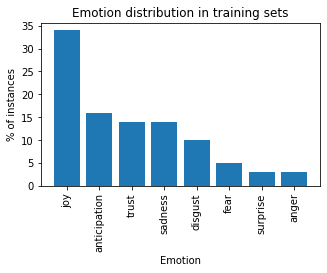

In [73]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = traindata['emotion'].unique()
post_total = len(traindata)
df1 = traindata['emotion'].value_counts()
df1 = df1.apply(lambda x: round(x*100/post_total))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution in training sets')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

the data is highly imbalance so i'll try to upsampling later to see if the model will perform better

# 2. Feature engineering

I split the data for training and testing the model

In [40]:
from sklearn.model_selection import train_test_split
X = traindata.cleantext
y = traindata.emotion
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

see the distribution between train&test dataset

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# the histogram of the data
labels = y_train.unique()
post_total = len(y_train)
df1 = y_train.value_counts()
df1 = df1.apply(lambda x: round(x*100/post_total))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution in training sets')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

# the histogram of the data
labels = y_test.unique()
post_total = len(y_test)
df1 = y_test.value_counts()
df1 = df1.apply(lambda x: round(x*100/post_total,3))

#plot
fig, ax = plt.subplots(figsize=(5,3))
plt.bar(df1.index,df1.values)

#arrange
plt.ylabel('% of instances')
plt.xlabel('Emotion')
plt.title('Emotion distribution  in testing sets')
plt.grid(False)
plt.xticks(rotation=90)
plt.show()

## 2.1 Bag of word (countvectorizer)

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
BOW_vectorizer = CountVectorizer(stop_words='english') 
BOW_vectorizer.fit(X_train)
train_data_vectorizer_features=BOW_vectorizer.transform(X_train)

## 2.2 Tfidfvertorizer

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer
Tfidfvertorizer = TfidfVectorizer(stop_words = "english")
train_data_Tfidf_features = Tfidfvertorizer.fit_transform(X_train)

## 2.3 nltktokenizer

In [43]:
from nltk.tokenize import  word_tokenize
word_tokenize = CountVectorizer(tokenizer = word_tokenize,stop_words='english')
train_data_tweet_features = word_tokenize.fit_transform(X_train)

## 2.4 other tokenizer

In [44]:
from nltk.tokenize import (TreebankWordTokenizer,
                           word_tokenize,
                           wordpunct_tokenize,
                           TweetTokenizer,
                           MWETokenizer)
wordpuncttokenize = CountVectorizer(tokenizer = wordpunct_tokenize,stop_words='english')
train_data_wordpuncttokenize_features = wordpuncttokenize.fit_transform(X_train)





from tokenizers import (BertWordPieceTokenizer)
bert_tokenizer = BertWordPieceTokenizer("bert-base-uncased-vocab.txt", lowercase=True)


# 3 Model&Evaluation

## 3.1 Naive Bayes Classifier

Naive Bayes (NB) is a common model for document classification. The main concept of Naive Bayes is to use the Bayes’ Theorem to estimate the joint probability of all the different words conditioned on each label.

after trying every tokenizer I found that countvect with default tokenizer gave me the best resut so I use it

In [45]:
allemo = ['joy','sadness','trust','anticipation','disgust','surprise','anger','fear']

In [46]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline, FeatureUnion


%%time
from sklearn.naive_bayes import MultinomialNB
nb_BOW = Pipeline([('vect', BOW_vectorizer),
               ('clf', MultinomialNB()),
              ])
nb_BOW.fit(X_train, y_train)


y_pred = nb_BOW.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))
#accuracy 0.5023104811149743

PRED= nb_BOW.predict(Testdata['cleantext'])

Testdata['emotion']=PRED

Testdata

Testdata[['id','emotion']].to_csv('NB_BOW.csv', sep=',', encoding='utf-8')

%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
nb_tfidf = Pipeline([('vect', Tfidfvertorizer),
               ('clf', MultinomialNB()),
              ])
nb_tfidf.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb_tfidf.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))
#accuracy 0.4445335948411637

%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
nb_word = Pipeline([('vect', word_tokenize),
               ('clf', MultinomialNB()),
              ])
nb_word.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb_word.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

PRED= nb_word.predict(Testdata['cleantext'])

Testdata['emotion']=PRED

Testdata[['id','emotion']].to_csv('NB_WORD.csv', sep=',', encoding='utf-8')

%%time
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
nb_wordpuncttokenize = Pipeline([('vect', wordpuncttokenize),
               ('clf', MultinomialNB()),
              ])
nb_wordpuncttokenize.fit(X_train, y_train)


from sklearn.metrics import classification_report
y_pred = nb_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))
#accuracy 0.5023327687141541


PRED= nb_wordpuncttokenize.predict(Testdata['cleantext'])

Testdata['emotion']=PRED

Testdata[['id','emotion']].to_csv('NB_wordpuncttokenize.csv', sep=',', encoding='utf-8')

%%time
#text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SVC(kernel='rbf'))])

from sklearn.naive_bayes import MultinomialNB
nb_BOW = Pipeline([('vect', BOW_vectorizer),('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb_BOW.fit(X_train, y_train)


y_pred = nb_BOW.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))
#accuracy 0.4445335948411637

%%time
#text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SVC(kernel='rbf'))])

from sklearn.naive_bayes import MultinomialNB
nb_BOW = Pipeline([('vect', wordpuncttokenize),('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb_BOW.fit(X_train, y_train)


y_pred = nb_BOW.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))


# 3.2 SGDClassifier

%%time
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import SGDClassifier

sgd_wordpuncttokenize = Pipeline([('vect',  wordpuncttokenize),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=10, tol=None)),
               ])
sgd_wordpuncttokenize.fit(X_train, y_train)



y_pred = sgd_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

%%time
from sklearn.linear_model import SGDClassifier
#CountVectorizer(stop_words='english')
sgd_BOW = Pipeline([('vect', BOW_vectorizer),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=10, tol=None)),
               ])
sgd_BOW.fit(X_train, y_train)



y_pred = sgd_BOW.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

#Tfidfvertorizer
%%time
from sklearn.linear_model import SGDClassifier

sgd_TfidfTransformer = Pipeline([('vect', TfidfTransformer(smooth_idf=True,use_idf=True)),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=10, tol=None)),
               ])
sgd_TfidfTransformer.fit(X_train, y_train)



y_pred = sgd_TfidfTransformer.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

In [47]:
error

NameError: name 'error' is not defined

--------------------------------------------

# 3.3 LogisticRegression

%%time
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
#CountVectorizer(stop_words='english')
logreg_BOW = Pipeline([('vect', BOW_vectorizer),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg_BOW.fit(X_train, y_train)



y_pred = logreg_BOW.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo))

PRED= logreg_BOW.predict(Testdata['cleantext'])

Testdata['emotion']=PRED

#Testdata

Testdata[['id','emotion']].to_csv('LR_BOW.csv', sep=',', encoding='utf-8')

%%time
from sklearn.linear_model import LogisticRegression

logreg_wordpuncttokenize = Pipeline([('vect', wordpuncttokenize),('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg_wordpuncttokenize.fit(X_train, y_train)



y_pred = logreg_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 
#accuracy 0.5060473685774568
#accuracy 0.4976820896852991 add ('tfidf', TfidfTransformer())  become worse

%%time
from sklearn.linear_model import LogisticRegression

logreg_Tfidfvertorizer = Pipeline([('vect', Tfidfvertorizer),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg_Tfidfvertorizer.fit(X_train, y_train)



y_pred = logreg_Tfidfvertorizer.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

# word_tokenize
from sklearn.linear_model import LogisticRegression

logreg_word_tokenize = Pipeline([('vect', word_tokenize),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg_word_tokenize.fit(X_train, y_train)



y_pred = logreg_word_tokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

# #text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SVC(kernel='rbf'))])
from sklearn.linear_model import LogisticRegression

logreg_word_tokenize = Pipeline([('vect', word_tokenize), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg_word_tokenize.fit(X_train, y_train)



y_pred = logreg_word_tokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

## Transformer

In [ ]:
error

## CNN

In [66]:
#I replace old keras to new onw(tensorflow keras)
# 
#from keras.models import Model
#from keras.layers import Input, Dense
#from keras.layers import ReLU, Softmax

import tensorflow as tf 
keras = tf.keras

from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Embedding
from tensorflow.keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Reshape, Dropout, Dense,Multiply, Dot, Concatenate,Embedding,ReLU, Softmax
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Input,Conv1D,MaxPooling1D,Dense,GlobalMaxPooling1D,Embedding
from tensorflow.keras.models import Model
import numpy as np

In [67]:
import nltk

# build analyzers (bag-of-words)
BOW_500_word_tokenize = CountVectorizer(max_features=500, tokenizer=nltk.word_tokenize) 


# apply analyzer to training data
BOW_500_word_tokenize.fit(traindata['cleantext'])

train_data_BOW_features_500 = BOW_500_word_tokenize.transform(traindata['cleantext'])


In [68]:
import nltk

#wordpunct_tokenize
BOW_500_wordpunct_tokenize = CountVectorizer(max_features=500, tokenizer=nltk.wordpunct_tokenize) 


# apply analyzer to training data
BOW_500_wordpunct_tokenize.fit(traindata['cleantext'])

train_data_wordpunctfeatures_500 = BOW_500_wordpunct_tokenize.transform(traindata['cleantext'])


In [72]:
# standardize name (X, y) 
X_train = BOW_500_wordpunct_tokenize.transform(traindata['cleantext'])
y_train = traindata['emotion']

X_test = BOW_500_wordpunct_tokenize.transform(Testdata['cleantext'])
y_test = Testdata['emotion']

## check dimension is a good habbit 
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

KeyError: 'emotion'

In [ ]:
## deal with label (string -> one-hot)

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train)
print('check label: ', label_encoder.classes_)
print('\n## Before convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)

def label_encode(le, labels):
    enc = le.transform(labels)
    return keras.utils.to_categorical(enc)

def label_decode(le, one_hot_label):
    dec = np.argmax(one_hot_label, axis=1)
    return le.inverse_transform(dec)

y_train = label_encode(label_encoder, y_train)
y_test = label_encode(label_encoder, y_test)

print('\n\n## After convert')
print('y_train[0:4]:\n', y_train[0:4])
print('\ny_train.shape: ', y_train.shape)
print('y_test.shape: ', y_test.shape)


In [ ]:
# I/O check
input_shape = X_train.shape[1]
print('input_shape: ', input_shape)

output_shape = len(label_encoder.classes_)
print('output_shape: ', output_shape)

In [ ]:

# input layer
model_input = Input(shape=(input_shape, ))  # 500
X = model_input

# 1st hidden layer
X_W1 = Dense(units=64)(X)  # 64
H1 = ReLU()(X_W1)

# 2nd hidden layer
H1_W2 = Dense(units=64)(H1)  # 64
H2 = ReLU()(H1_W2)

# output layer
H2_W3 = Dense(units=output_shape)(H2)  # 4
H3 = Softmax()(H2_W3)

model_output = H3

# create model
model = Model(inputs=[model_input], outputs=[model_output])

# loss function & optimizer
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# show model construction
model.summary()

In [ ]:
from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger('training_log.csv')

# training setting
epochs = 10
batch_size = 32

# training!
history = model.fit(X_train, y_train, 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[csv_logger],
                    validation_data = (X_test, y_test))
print('training finish')

In [ ]:
## predict
pred_result = model.predict(X_test, batch_size=128)
pred_result[:5]

In [ ]:
pred_result = label_decode(label_encoder, pred_result)
pred_result[:5]

from sklearn.metrics import accuracy_score

print('testing accuracy: {}'.format(round(accuracy_score(label_decode(label_encoder, y_test), pred_result), 2)))

In [ ]:
Testdata['emotion']=pred_result

In [ ]:
Testdata[['id','emotion']].to_csv('CNN.csv', sep=',', encoding='utf-8')

In [ ]:
error

# 3.4 RandomForestClassifier

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfTransformer
stemmer = SnowballStemmer("english", ignore_stopwords=True)
class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])
stemmed_count_vect = StemmedCountVectorizer(stop_words='english')
text_mnb_stemmed = Pipeline([('vect', stemmed_count_vect),
                    ('tfidf', TfidfTransformer()),
                      ('mnb', MultinomialNB(fit_prior=False)), 
                            ])
text_mnb_stemmed = text_mnb_stemmed.fit(X_train, y_train)
y_pred = text_mnb_stemmed.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

In [ ]:
#https://www.kaggle.com/code/alokmalik/text-classification-using-svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
                        random_state=1)


#Use pipeline to carry out steps in sequence with a single object
#SVM's rbf kernel gives highest accuracy in this classification problem.

#('vect', wordpuncttokenize)
#RF_CountVectorizer = Pipeline([('vect', CountVectorizer(stop_words='english')), ('clf', RandomForestClassifier())])
bag_wordpuncttokenize = Pipeline([('vect', wordpuncttokenize), ('clf', bag)])
             
bag_wordpuncttokenize.fit(X_train, y_train)

y_pred = bag_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

In [ ]:
PRED= bag_wordpuncttokenize.predict(Testdata['cleantext'])

Testdata['emotion']=PRED

#Testdata

Testdata[['id','emotion']].to_csv('BaggingClassifier_wordpuncttokenize.csv', sep=',', encoding='utf-8')

In [ ]:
#text_clf = Pipeline([('vect', CountVectorizer()), ('tfidf', TfidfTransformer()), ('clf', SVC(kernel='rbf'))])


In [ ]:
#https://www.kaggle.com/code/alokmalik/text-classification-using-svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

RF_wordpuncttokenize = Pipeline([('vect', wordpuncttokenize), ('clf', RandomForestClassifier())])

             
RF_wordpuncttokenize.fit(X_train, y_train)

y_pred = RF_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

In [ ]:
PRED= RF_wordpuncttokenize.predict(Testdata['cleantext'])

Testdata['emotion']=PRED

#Testdata

Testdata[['id','emotion']].to_csv('RF_wordpuncttokenize.csv', sep=',', encoding='utf-8')

In [ ]:
#https://www.kaggle.com/code/alokmalik/text-classification-using-svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion

#Use pipeline to carry out steps in sequence with a single object
#SVM's rbf kernel gives highest accuracy in this classification problem.

#('vect', wordpuncttokenize)
#RF_CountVectorizer = Pipeline([('vect', CountVectorizer(stop_words='english')), ('clf', RandomForestClassifier())])
#

RF_BOW_vectorizer = Pipeline([('vect', BOW_vectorizer), ('clf', RandomForestClassifier())])
             
RF_BOW_vectorizer.fit(X_train, y_train)

y_pred = RF_BOW_vectorizer.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

# 3.5 SVC

In [ ]:
#https://www.kaggle.com/code/alokmalik/text-classification-using-svm
from sklearn.svm import SVC# Support Vector Machine

#Use pipeline to carry out steps in sequence with a single object
#SVM's rbf kernel gives highest accuracy in this classification problem.

#('vect', wordpuncttokenize)
svc_wordpuncttokenize = Pipeline([('vect', wordpuncttokenize), ('clf', SVC(kernel='rbf'))])
            
svc_wordpuncttokenize.fit(X_train, y_train)



y_pred = svc_wordpuncttokenize.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 



In [ ]:
PRED= svc_wordpuncttokenize.predict(Testdata['cleantext'])

Testdata['emotion']=PRED

#Testdata

Testdata[['id','emotion']].to_csv('svc_wordpuncttokenize.csv', sep=',', encoding='utf-8')

In [ ]:
#https://www.kaggle.com/code/alokmalik/text-classification-using-svm
from sklearn.svm import SVC# Support Vector Machine

#Use pipeline to carry out steps in sequence with a single object
#SVM's rbf kernel gives highest accuracy in this classification problem.

#('vect', wordpuncttokenize)
svc_CountVectorizer = Pipeline([('vect', CountVectorizer(stop_words='english')), ('clf', SVC(kernel='rbf'))])
            
svc_CountVectorizer.fit(X_train, y_train)



y_pred = svc_CountVectorizer.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=allemo)) 

# 3.4 FASTTEXT(Best score)

Format data & export to TXT because fasttext read data from text file

In [ ]:
hyper_params = {"lr": 0.01,
                "epoch": 14,
                "wordNgrams": 2,
                "dim": 20}    

In [ ]:
traindata['data'] = traindata['cleantext']+'__label__'+traindata['emotion']

In [ ]:
traindata['data'].to_csv('fastnotokay1.txt')

Trainmodel&evaluate

In [ ]:
import fasttext

In [ ]:
model = fasttext.train_supervised('fastnotokay1.txt',**hyper_params)
print("Model trained with the hyperparameter \n {}".format(hyper_params))

In [ ]:
traindata['cleantext'][1]

In [ ]:
model.predict(traindata['cleantext'][1])

Evaluate kaggle test dataset

In [ ]:
Testdata['emotion'] = Testdata['cleantext'].apply(lambda x: model.predict(x))

In [ ]:
Testdata[['id','emotion']].to_csv('FAST22ngram.csv', sep=',', encoding='utf-8')

In [ ]:
# For Building the model
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns

------------------------------------------------

# Conclusion
## Insights gained.

- between these models I tried, I foud that Fasttext give me the best result on the competition with very fast training time 
- text from twitter are really messy so the text cleaning is very important (I go back many times to do the text cleaning)
- this case BOW is better than Tfidf, may be the frequent word is really help us to classify but idf removed it.(at first I think TFIDF would perform better)

# Things I want to improve/try

- other language models like bert(I've tried roberta but my computer keep dying & the estimated time train are 10 days ;(
- try upsampling/other method to deal with the data imbalance.Because the majority of the data labels are 'joy,' so the model may be difficult to predict other emotions.
- the spell check because text from social contain many typo (I've tried spellchecker/textblob but it took too long)
- too many repeated words in tweet text I found when i plot a boxplot, I wantto remove them.
- word2vec